# On-policy bandit vs Greedy off-policy optimised policies
This notebook shows an empirical experiment comparing selection of bandit algorithms with off-policy optimised policies.

We present two experiments that try to answer the following research questions
1. What is the effect of the number of rounds (training data) on the difference in reward of on-policy vs off-policy?
2. What is the difference between reward between different types of bandit algorithms when used as logged data for an Inverse Propensity Weighting (IPW) learner.

Both experiments in this notebook have the following setup.
- The environment is stationary
- Feedback is instant (no delay)
- Bandit algorithms keep exploring / learning during the evaluation cycle
- Propensities for the IPW are learned by fitting a classifier predicting $P(A=a|c)$ on the training or evaluation dataset. Note that we fit a separate propensity model for the training and evaluation data and predict on the same dataset as it was trained on.

In [3]:
import copy

import numpy as np
from sklearn.linear_model import LogisticRegression

from obp.policy.offline import IPWLearner
from obp.dataset import logistic_sparse_reward_function
from obp.policy import Random, EpsilonGreedy, BernoulliTS, LinTS

from sklearn.ensemble import RandomForestClassifier as RandomForest

from obp.simulator.simulator import BanditEnvironmentSimulator, BanditPolicySimulator


### Off-policy vs on-policy at different number of rounds
In this section, we show how various bandit algorithms can be compared to an IPW learning given the amount of training and evaluation rounds.

In [4]:
%%time
experiment_round_size = [1000, 10000, 100000, 500000, 1000000]
n_runs_per_round_size = 20
n_actions = 5
dim_context = 5

bandit_policies = [
    (Random, {"n_actions": n_actions, "epsilon": 1.0, "random_state": 12345}),
    (BernoulliTS, {"n_actions": n_actions, "random_state": 12345}),
    (LinTS, {"dim": dim_context, "n_actions": n_actions, "random_state": 12345}),
    (EpsilonGreedy, {"n_actions": n_actions, "epsilon": 0.1, "random_state": 12345}),
]

dummy_policies = [policy_class(**args) for policy_class, args in bandit_policies]
train_rewards = {policy.policy_name: [] for policy in dummy_policies}
eval_rewards = {**copy.deepcopy(train_rewards), **{IPWLearner.__name__: []}}
train_rewards["n_rounds"] = []
eval_rewards["n_rounds"] = []

# In this setting the dataset is static, so we can use the same dataset class and redraw batches
# for different settings. When drift or delay is added the dataset object needs to be reinitiated with a new seed
# for each experiment.
env = BanditEnvironmentSimulator(
    n_actions=10,
    dim_context=5,
    reward_type="binary", # "binary" or "continuous"
    reward_function=logistic_sparse_reward_function,
    random_state=12345,
)

for n_rounds in experiment_round_size:
    for experiment in range(n_runs_per_round_size):
        training_bandit_batch = env.next_bandit_round_batch(n_rounds=n_rounds)
        evaluation_bandit_batch = env.next_bandit_round_batch(n_rounds=n_rounds)

        # Train the bandit algorithms and get the rewards for the training and evaluation period
        for policy_class, args in bandit_policies:
            policy = policy_class(**args)

            training_simulator = BanditPolicySimulator(policy=policy)

            training_simulator.steps(batch_bandit_rounds=training_bandit_batch)
            train_rewards[policy.policy_name].append(training_simulator.total_reward)

            eval_simulator = BanditPolicySimulator(policy=policy)

            eval_simulator.steps(batch_bandit_rounds=evaluation_bandit_batch)
            eval_rewards[policy.policy_name].append(eval_simulator.total_reward)

        # Train a propensity model on the actions in the training period to get propensities per round
        propensity_model = LogisticRegression(random_state=12345)
        propensity_model.fit(training_simulator.contexts, training_simulator.selected_actions)
        pscores = propensity_model.predict_proba(training_simulator.contexts)

        # Train an IPW learning from the logged data and learned propensities
        ipw_learner = IPWLearner(n_actions=env.n_actions,
                                 base_classifier=RandomForest(n_estimators=30, min_samples_leaf=10, random_state=12345))

        ipw_learner.fit(
            context=training_simulator.contexts,
            action=training_simulator.selected_actions,
            reward=training_simulator.obtained_rewards,
            pscore=np.choose(training_simulator.selected_actions, pscores.T)
        )
        eval_action_dists = ipw_learner.predict(
            context=eval_simulator.contexts
        )

        eval_rewards[ipw_learner.policy_name].append(
            np.sum(eval_action_dists.squeeze(axis=2) * evaluation_bandit_batch.rewards)
        )

        train_rewards["n_rounds"].append(n_rounds)
        eval_rewards["n_rounds"].append(n_rounds)




100%|██████████| 1000000/1000000 [00:08<00:00, 123562.29it/s]


CPU times: user 4h 51min 1s, sys: 16min 43s, total: 5h 7min 44s
Wall time: 4h 41min 52s


In [5]:
import seaborn as sns
import pandas as pd

The plot below compares the off-policy model to different on-policy bandit algorithms on the evaluation dataset.

IPWLearning has been allowed to learn from n_rounds of samples from the logged training data, the other policies have been exploring on n_rounds and can now exploit (and learn) on the evaluation data.

The plot compares the average reward per model. We clearly see that after $10^4$ IPWLearning start outperforming all on-policy models reaching an average reward of around .65 vs the highest on-policy reward of .56. Additionally, the on-policy models do not seem to increase their performance after $10^4$ rounds.

This seems to indicate that using an off-policy method to optimise your bandit model can yield higher performance than continious learning with on-policy models.

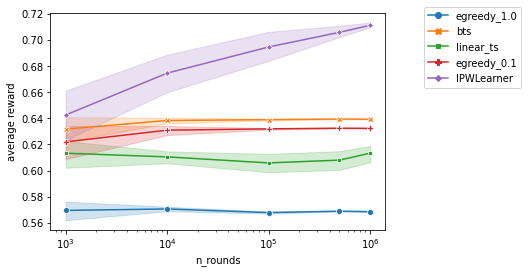

In [10]:
def plot_average_reward_per_n_rounds(rewards):
    rewards_pd = pd.DataFrame(rewards)
    rewards_pd = pd.melt(rewards_pd, ['n_rounds'])
    rewards_pd["average reward"] = rewards_pd["value"] / rewards_pd["n_rounds"]

    plot = sns.lineplot(data=rewards_pd, x="n_rounds", y="average reward", style="variable", hue="variable", markers=True, dashes=False)
    plot.set(xscale='log')
    plot.legend(bbox_to_anchor=(1.1, 1.05))

plot_average_reward_per_n_rounds(eval_rewards)



### Off-policy on different kinds of bandit policy logs
Understanding how counterfactual examples affect the performance of various off-policy optimisers can be useful in deciding which strategy for data collection to take.

In this next section, we run a bandit algorithm in order to collect logs that can be used for off-policy learning. These logs are used to train a propensity model for fitting a IPW model to be used for evaluation.

In [42]:
%%time
experiment_round_size = [1000, 10000, 100000, 500000, 1000000]
n_runs_per_round_size = 20
n_actions = 5
dim_context = 5

bandit_policies = [
    (Random, {"n_actions": n_actions, "epsilon": 1.0, "random_state": 12345}),
    (BernoulliTS, {"n_actions": n_actions, "random_state": 12345}),
    (LinTS, {"dim": dim_context, "n_actions": n_actions, "random_state": 12345}),
    (EpsilonGreedy, {"n_actions": n_actions, "epsilon": 0.1, "random_state": 12345}),
]

dummy_policies = [policy_class(**args) for policy_class, args in bandit_policies]
train_rewards = {policy.policy_name: [] for policy in dummy_policies}
eval_rewards = {f"{IPWLearner.__name__} {policy.policy_name}": [] for policy in dummy_policies}
train_rewards["n_rounds"] = []
eval_rewards["n_rounds"] = []

# In this setting the dataset is static, so we can use the same dataset class and redraw batches
# for different settings. When drift or delay is added the dataset object needs to be reinitiated with a new seed
# for each experiment.
env = BanditEnvironmentSimulator(
    n_actions=10,
    dim_context=5,
    reward_type="binary",
    reward_function=logistic_sparse_reward_function,
    random_state=12345,
)

for n_rounds in experiment_round_size:
    for experiment in range(n_runs_per_round_size):
        training_bandit_batch = env.next_bandit_round_batch(n_rounds=n_rounds)
        evaluation_bandit_batch = env.next_bandit_round_batch(n_rounds=n_rounds)

        # Train the bandit algorithms and get the rewards for the training and evaluation period
        for policy_class, args in bandit_policies:
            policy = policy_class(**args)

            training_simulator = BanditPolicySimulator(policy=policy)

            training_simulator.steps(batch_bandit_rounds=training_bandit_batch)
            train_rewards[policy.policy_name].append(training_simulator.total_reward)

            # Train a propensity model on the actions in the training period to get propensities per round
            propensity_model = LogisticRegression(random_state=12345)
            propensity_model.fit(training_simulator.contexts, training_simulator.selected_actions)
            pscores = propensity_model.predict_proba(training_simulator.contexts)

            # Train an IPW learning from the logged data and learned propensities
            ipw_learner = IPWLearner(n_actions=env.n_actions,
                                     base_classifier=RandomForest(n_estimators=30, min_samples_leaf=10, random_state=12345))

            ipw_learner.fit(
                context=training_simulator.contexts,
                action=training_simulator.selected_actions,
                reward=training_simulator.obtained_rewards,
                pscore=np.choose(training_simulator.selected_actions, pscores.T)
            )
            eval_action_dists = ipw_learner.predict(
                context=evaluation_bandit_batch.context
            )

            eval_rewards[f"{ipw_learner.policy_name} {policy.policy_name}"].append(
                np.sum(eval_action_dists.squeeze(axis=2) * evaluation_bandit_batch.rewards)
            )

        train_rewards["n_rounds"].append(n_rounds)
        eval_rewards["n_rounds"].append(n_rounds)



100%|██████████| 1000000/1000000 [00:09<00:00, 104142.44it/s]


CPU times: user 4h 53min 32s, sys: 54min 7s, total: 5h 47min 40s
Wall time: 4h 30min 31s


The plot below shows how the performance of the same IPW model setup can significantly differ when the underlying data collection process changes.

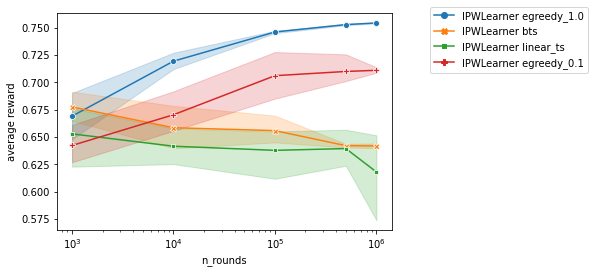

In [30]:
plot_average_reward_per_n_rounds(eval_rewards)
